# Movie Recommendation System Overview

This notebook provides an overview of our movie recommendation system pipeline, from data collection to model training and serving. We'll explore:

1. **Data Collection**: Fetching movie data from TheMovieDB API
2. **Data Exploration**: Understanding the movie dataset structure
3. **Feature Engineering**: Creating features for the recommendation model
4. **Model Training**: Building a content-based recommendation system
5. **Model Evaluation**: Testing the recommendation quality
6. **Example Recommendations**: Demonstrating how the system works


In [ ]:
# Setup and Imports

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any
import json
from pathlib import Path

# For semantic search and embeddings
from sentence_transformers import SentenceTransformer
import torch

# Add the parent directory to the path to import from src
sys.path.append('..')


In [ ]:
# 1. Connect to Supabase Database

import os
from dotenv import load_dotenv
from supabase import create_client, Client

# Load environment variables from a .env file (create this file with your credentials)
load_dotenv()

# Initialize Supabase client
supabase_url = os.getenv("SUPABASE_URL")
supabase_key = os.getenv("SUPABASE_KEY")

# Check if credentials are available
if not supabase_url or not supabase_key:
    print("Supabase credentials not found. Please set SUPABASE_URL and SUPABASE_KEY environment variables.")
    # For demonstration, we'll use a sample dataset if no credentials are available
else:
    # Initialize Supabase client
    supabase: Client = create_client(supabase_url, supabase_key)
    print("Connected to Supabase!")


Connected to Supabase!


In [ ]:
import os
import requests
from pathlib import Path
import json

def get_genre_mapping(api_key: str,
                      language: str = "en",
                      cache_path: Path | None = Path("tmdb_genres.json")) -> dict[int, str]:
    """
    Trả về dict {genre_id: genre_name} lấy từ TMDB.
    Nếu `cache_path` tồn tại thì ưu tiên đọc cache để tránh gọi API nhiều lần.
    """
    # 1) Đọc cache nếu có
    if cache_path and cache_path.exists():
        with open(cache_path, "r", encoding="utf-8") as f:
            return {int(k): v for k, v in json.load(f).items()}

    # 2) Gọi API
    url = "https://api.themoviedb.org/3/genre/movie/list"
    params = {"language": language, "api_key": api_key}
    resp = requests.get(url, params=params, timeout=10)
    resp.raise_for_status()          # Báo lỗi sớm nếu mã trạng thái ≠ 200

    genres = resp.json()["genres"]
    genre_map = {g["id"]: g["name"] for g in genres}

    # 3) Lưu cache (tùy chọn)
    if cache_path:
        with open(cache_path, "w", encoding="utf-8") as f:
            json.dump(genre_map, f, ensure_ascii=False, indent=2)

    return genre_map

# --- Cách dùng ---------------------------------------------------------------
API_KEY = os.getenv("TMDB_API_KEY")        # bạn nên đặt biến môi trường TMDB_API_KEY
genre_mapping = get_genre_mapping(API_KEY, language="en")

In [6]:
# 2. Fetch and Explore Movie Data

# Function to fetch data from Supabase or load sample data
def get_movie_data():
    try:
        if 'supabase' in globals():
            # Fetch from Supabase if connected
            response = supabase.table('movies').select('*').execute()
            return pd.DataFrame(response.data)
        else:
            # Load sample data for demonstration
            return load_sample_data()
    except Exception as e:
        print(f"Error fetching data: {e}")
        return load_sample_data()

# Function to load sample data if Supabase connection is not available
def load_sample_data():
    # Sample movie data structure
    sample_data = [
        {
            "id": 238,
            "title": "The Godfather",
            "overview": "Spanning the years 1945 to 1955, a chronicle of the fictional Italian-American Corleone crime family...",
            "release_date": "1972-03-14",
            "popularity": 105.761,
            "vote_average": 8.7,
            "vote_count": 18327,
            "genre_ids": [18, 80],  # Drama, Crime
            "keywords": ["mafia", "patriarch", "crime family", "organized crime", "vendetta"],
            "cast": ["Marlon Brando", "Al Pacino", "James Caan"]
        },
        {
            "id": 278,
            "title": "The Shawshank Redemption",
            "overview": "Framed in the 1940s for the double murder of his wife and her lover...",
            "release_date": "1994-09-23",
            "popularity": 83.552,
            "vote_average": 8.7,
            "vote_count": 24451,
            "genre_ids": [18, 80],  # Drama, Crime
            "keywords": ["prison", "friendship", "corruption", "escape", "redemption"],
            "cast": ["Tim Robbins", "Morgan Freeman", "Bob Gunton"]
        },
        # Add more sample movies here
    ]
    
    return pd.DataFrame(sample_data)

# Get movie data
movies_df = get_movie_data()

# Display basic information
print(f"Dataset shape: {movies_df.shape}")
movies_df.head()


Dataset shape: (1000, 11)


,id,title,overview,release_date,popularity,vote_average,vote_count,poster_path,genre_ids,keywords,top_cast
0,568332,Taylor Swift: Reputation Stadium Tour,Taylor Swift takes the stage in Dallas for the...,2018-12-31,0.9459,8.241,406,/u6oXUTtOuJRPdUgUuPAVVJPSKCo.jpg,[10402],"[concert, live performance, concert film]","[Taylor Swift, Charli xcx, Camila Cabello]"
1,504253,I Want to Eat Your Pancreas,After his classmate and crush is diagnosed wit...,2018-09-01,6.1639,8.240,1631,/qDWA7fB4cZ4sBP6YgwlxvraDHi7.jpg,"[16, 18, 10749]","[based on novel or book, terminal illness, tra...","[Mahiro Takasugi, Lynn, Yukiyo Fujii]"
2,299534,Avengers: Endgame,After the devastating events of Avengers: Infi...,2019-04-24,17.9296,8.240,26460,/ulzhLuWrPK07P1YkdWQLZnQh1JL.jpg,"[12, 878, 28]","[superhero, time travel, space travel, time ma...","[Robert Downey Jr., Chris Evans, Mark Ruffalo]"
3,447362,Life in a Year,A 17 year old finds out that his girlfriend is...,2020-11-27,3.4222,8.200,1919,/bP7u19opmHXYeTCUwGjlLldmUMc.jpg,"[18, 10749]",[],"[Jaden Smith, Cara Delevingne, Cuba Gooding Jr.]"
4,508965,Klaus,When Jesper distinguishes himself as the Posta...,2019-11-08,4.5778,8.237,4301,/q125RHUDgR4gjwh1QkfYuJLYkL.jpg,"[16, 10751, 12, 35, 14]","[friendship, small town, island, holiday, sant...","[Jason Schwartzman, J.K. Simmons, Rashida Jones]"


In [ ]:
# Kiểm tra và xử lý dữ liệu thiếu

# Hiển thị số lượng giá trị thiếu trong mỗi cột
print("Số lượng giá trị thiếu trong mỗi cột:")
missing_values = movies_df.isnull().sum()
missing_percentage = (missing_values / len(movies_df)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})
print(missing_df[missing_df['Missing Values'] > 0])

# Kiểm tra và xử lý các giá trị trống trong các trường quan trọng
def check_empty_lists(movies_df):
    """Kiểm tra các trường danh sách (list) có rỗng hoặc null không"""
    list_columns = ['genre_ids', 'keywords', 'cast']
    empty_lists = {}
    
    for col in list_columns:
        if col in movies_df.columns:
            empty_count = 0
            null_count = 0
            for val in movies_df[col]:
                if val is None:
                    null_count += 1
                elif isinstance(val, list) and len(val) == 0:
                    empty_count += 1
            
            empty_lists[col] = {
                'empty_lists': empty_count,
                'null_values': null_count,
                'percentage_empty_or_null': ((empty_count + null_count) / len(movies_df)) * 100
            }
    
    return empty_lists

empty_list_stats = check_empty_lists(movies_df)
print("\nKiểm tra các trường danh sách rỗng:")
for col, stats in empty_list_stats.items():
    print(f"{col}: {stats['empty_lists']} danh sách rỗng, {stats['null_values']} giá trị null ({stats['percentage_empty_or_null']:.2f}%)")

# Xử lý các giá trị thiếu
def fill_missing_values(df):
    """Điền các giá trị thiếu trong DataFrame"""
    df_filled = df.copy()
    
    # Xử lý trường title
    if 'title' in df.columns and df['title'].isnull().sum() > 0:
        df_filled['title'] = df_filled['title'].fillna('Unknown Title')
    
    # Xử lý trường overview
    if 'overview' in df.columns and df['overview'].isnull().sum() > 0:
        df_filled['overview'] = df_filled['overview'].fillna('')
    
    # Xử lý các trường số
    numeric_cols = ['popularity', 'vote_average', 'vote_count']
    for col in numeric_cols:
        if col in df.columns and df[col].isnull().sum() > 0:
            # Điền giá trị thiếu bằng giá trị trung bình
            df_filled[col] = df_filled[col].fillna(df_filled[col].mean())
    
    # Xử lý trường ngày
    if 'release_date' in df.columns and df['release_date'].isnull().sum() > 0:
        # Dùng năm hiện tại nếu ngày phát hành bị thiếu
        df_filled['release_date'] = df_filled['release_date'].fillna('2023-01-01')
    
    # Xử lý các trường danh sách
    list_cols = ['genre_ids', 'keywords', 'cast']
    for col in list_cols:
        if col in df.columns:
            # Thay thế None và danh sách rỗng bằng danh sách mặc định
            df_filled[col] = df_filled[col].apply(lambda x: [] if x is None or (isinstance(x, list) and len(x) == 0) else x)
    
    return df_filled

# Điền các giá trị thiếu
movies_df_filled = fill_missing_values(movies_df)

# Kiểm tra lại sau khi điền giá trị thiếu
print("\nSau khi điền giá trị thiếu:")
missing_after = movies_df_filled.isnull().sum()
print(missing_after[missing_after > 0])

# Kiểm tra các danh sách rỗng sau khi xử lý
empty_list_stats_after = check_empty_lists(movies_df_filled)
print("\nKiểm tra các trường danh sách rỗng sau khi xử lý:")
for col, stats in empty_list_stats_after.items():
    print(f"{col}: {stats['empty_lists']} danh sách rỗng, {stats['null_values']} giá trị null ({stats['percentage_empty_or_null']:.2f}%)")

# Cập nhật DataFrame để sử dụng cho các bước tiếp theo
movies_df = movies_df_filled

Số lượng giá trị thiếu trong mỗi cột:
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []

Kiểm tra các trường danh sách rỗng:
genre_ids: 0 danh sách rỗng, 0 giá trị null (0.00%)
keywords: 34 danh sách rỗng, 0 giá trị null (3.40%)

Sau khi điền giá trị thiếu:
Series([], dtype: int64)

Kiểm tra các trường danh sách rỗng sau khi xử lý:
genre_ids: 0 danh sách rỗng, 0 giá trị null (0.00%)
keywords: 34 danh sách rỗng, 0 giá trị null (3.40%)


Basic statistics for numeric columns:


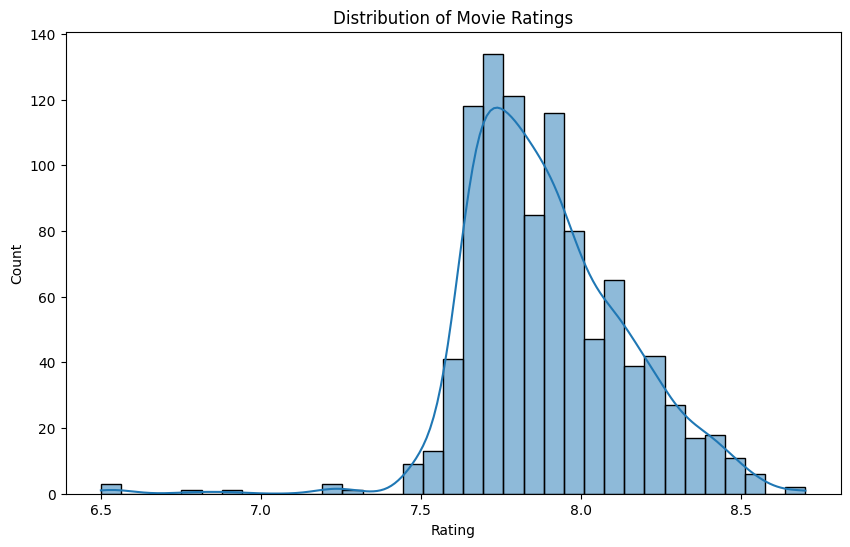

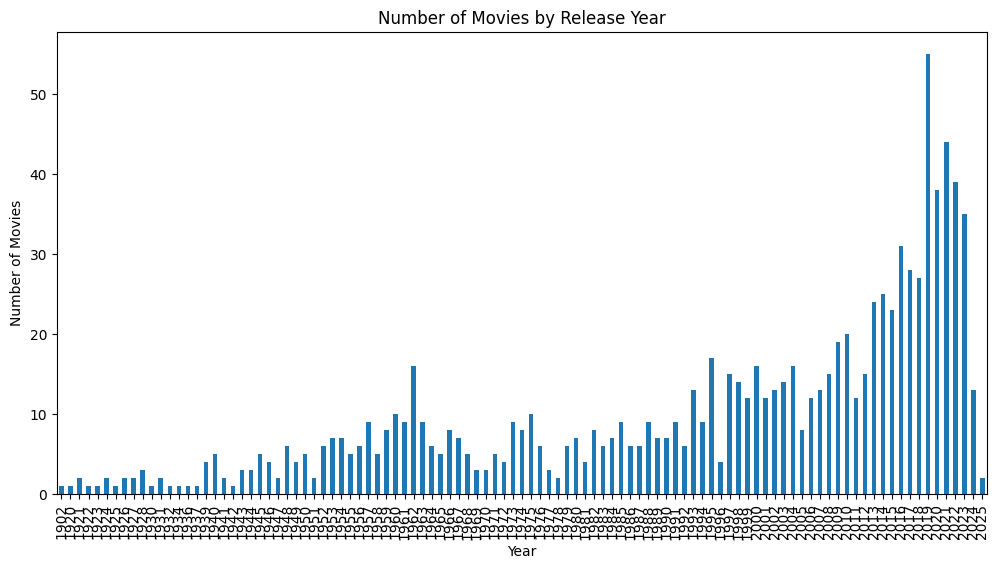

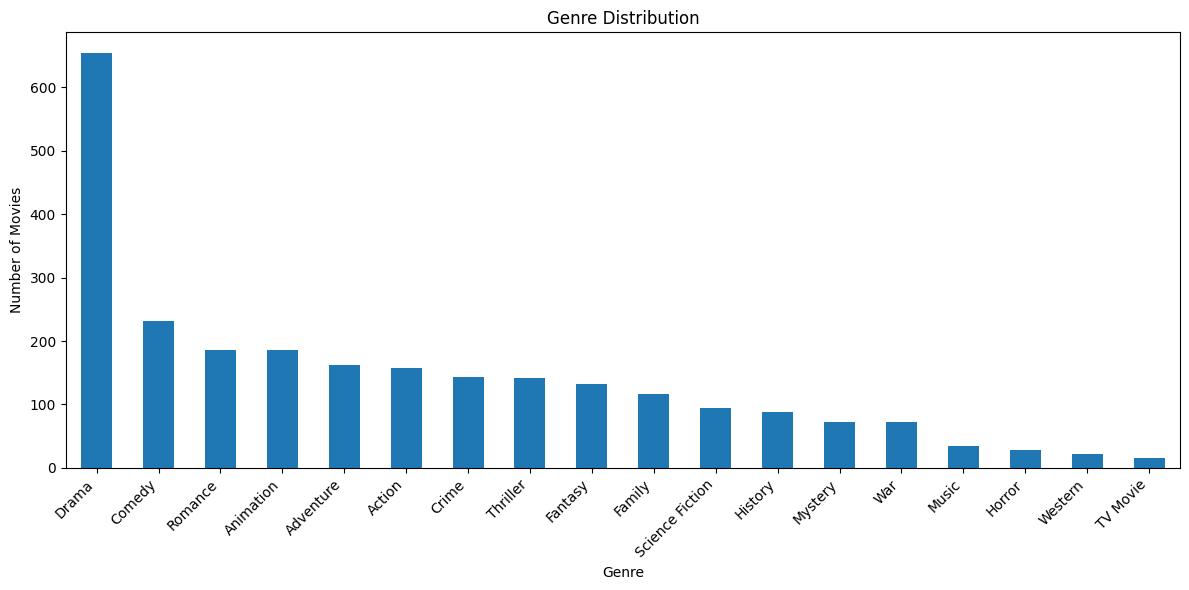

In [ ]:
# 3. Data Exploration and Analysis

# Let's explore some basic statistics of our movie dataset
print("Basic statistics for numeric columns:")
movies_df.describe()

# Plot distribution of vote averages
plt.figure(figsize=(10, 6))
sns.histplot(movies_df['vote_average'], kde=True)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Count movies by release year
if 'release_date' in movies_df.columns:
    movies_df['release_year'] = pd.to_datetime(movies_df['release_date']).dt.year
    
    plt.figure(figsize=(12, 6))
    yearly_counts = movies_df['release_year'].value_counts().sort_index()
    yearly_counts.plot(kind='bar')
    plt.title('Number of Movies by Release Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Movies')
    plt.xticks(rotation=90)
    plt.show()

# Explore genre distribution (assuming genre_ids is a list column)
def count_genres(movies_df):
    # Dictionary mapping genre IDs to names (you would typically get this from TMDB API)
    genre_mapping = {
        28: "Action", 12: "Adventure", 16: "Animation", 35: "Comedy", 80: "Crime",
        99: "Documentary", 18: "Drama", 10751: "Family", 14: "Fantasy", 36: "History",
        27: "Horror", 10402: "Music", 9648: "Mystery", 10749: "Romance", 878: "Science Fiction",
        10770: "TV Movie", 53: "Thriller", 10752: "War", 37: "Western"
    }
    
    # Count occurrences of each genre
    genre_counts = {}
    for _, movie in movies_df.iterrows():
        if 'genre_ids' in movie and isinstance(movie['genre_ids'], list):
            for genre_id in movie['genre_ids']:
                genre_name = genre_mapping.get(genre_id, f"Unknown ({genre_id})")
                genre_counts[genre_name] = genre_counts.get(genre_name, 0) + 1
    
    return pd.Series(genre_counts).sort_values(ascending=False)

if 'genre_ids' in movies_df.columns:
    genre_distribution = count_genres(movies_df)
    
    plt.figure(figsize=(12, 6))
    genre_distribution.plot(kind='bar')
    plt.title('Genre Distribution')
    plt.xlabel('Genre')
    plt.ylabel('Number of Movies')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [ ]:
# 4. Feature Engineering for Content-Based Recommendation

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Create a function to preprocess and engineer features for our recommendation system
def engineer_features(movies_df):
    # Make a copy to avoid modifying the original
    df = movies_df.copy()
    
    # Create a column with all text features combined
    df['combined_features'] = ''
    
    # Add title (with higher weight by repeating)
    df['combined_features'] += (df['title'] + ' ') * 3
    
    # Add overview
    if 'overview' in df.columns:
        df['combined_features'] += df['overview'] + ' '
    
    # Add genres
    # Add genres to combined features
    # Đã có genre_mapping ở trên
    if "genre_ids" in df.columns:
        for idx, row in df.iterrows():
            if isinstance(row["genre_ids"], list):
                genres = [genre_mapping.get(gid, "Unknown") for gid in row["genre_ids"]]
                df.at[idx, "combined_features"] += " ".join(genres) + " "
        
    
    # Add keywords (if available)
    if 'keywords' in df.columns:
        for idx, row in df.iterrows():
            if isinstance(row['keywords'], list):
                df.at[idx, 'combined_features'] += ' '.join(row['keywords']) + ' '
    
    # Add cast (if available)
    if 'cast' in df.columns:
        for idx, row in df.iterrows():
            if isinstance(row['cast'], list):
                df.at[idx, 'combined_features'] += ' '.join(row['cast']) + ' '
    
    return df

# Engineer features
movies_features_df = engineer_features(movies_df)

# Display sample of engineered features
print("Sample of combined features:")
movies_features_df[['title', 'combined_features']].head()


Sample of combined features:


,title,combined_features
0,Taylor Swift: Reputation Stadium Tour,Taylor Swift: Reputation Stadium Tour Taylor S...
1,I Want to Eat Your Pancreas,I Want to Eat Your Pancreas I Want to Eat Your...
2,Avengers: Endgame,Avengers: Endgame Avengers: Endgame Avengers: ...
3,Life in a Year,Life in a Year Life in a Year Life in a Year A...
4,Klaus,Klaus Klaus Klaus When Jesper distinguishes hi...


In [ ]:
# 5. Create and Train the Recommendation Model

# Use TF-IDF Vectorizer to convert text features to vectors
tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_features_df['combined_features'])

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Number of features: {len(tfidf_vectorizer.get_feature_names_out())}")

# Compute similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(f"Cosine similarity matrix shape: {cosine_sim.shape}")

# Create a reverse mapping of indices and movie titles
indices = pd.Series(movies_features_df.index, index=movies_features_df['title']).drop_duplicates()

# Function to get movie recommendations
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    try:
        idx = indices[title]
    except KeyError:
        print(f"Movie '{title}' not found in the dataset.")
        return pd.DataFrame()
    
    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the 10 most similar movies (excluding the movie itself)
    sim_scores = sim_scores[1:11]
    
    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]
    
    # Return the top 10 most similar movies with their similarity scores
    result = movies_df.iloc[movie_indices].copy()
    
    # Add similarity scores
    result['similarity_score'] = [i[1] for i in sim_scores]
    
    return result[['title', 'similarity_score', 'overview', 'vote_average']]

# Save the model artifacts
import joblib

# Save the vectorizer
vectorizer_path = '../models/tfidf_vectorizer.joblib'
os.makedirs('../models', exist_ok=True)
joblib.dump(tfidf_vectorizer, vectorizer_path)
print(f"Vectorizer saved to {vectorizer_path}")

# Save the similarity matrix
similarity_matrix_path = '../models/cosine_sim_matrix.joblib'
joblib.dump(cosine_sim, similarity_matrix_path)
print(f"Similarity matrix saved to {similarity_matrix_path}")

# Save the indices
indices_path = '../models/movie_indices.joblib'
joblib.dump(indices, indices_path)
print(f"Movie indices saved to {indices_path}")


TF-IDF matrix shape: (1000, 4898)
Number of features: 4898
Cosine similarity matrix shape: (1000, 1000)
Vectorizer saved to ../models/tfidf_vectorizer.joblib
Similarity matrix saved to ../models/cosine_sim_matrix.joblib
Movie indices saved to ../models/movie_indices.joblib


In [12]:
# 8. Advanced Semantic Search with Sentence Transformers

# Load the Sentence Transformer model
model_name = "sentence-transformers/all-MiniLM-L6-v2"
try:
    sentence_model = SentenceTransformer(model_name)
    print(f"Loaded Sentence Transformer model: {model_name}")
except Exception as e:
    print(f"Error loading Sentence Transformer model: {e}")
    print("Using sample embeddings for demonstration")
    sentence_model = None

# Function to compute movie embeddings
def compute_movie_embeddings(df):
    """
    Compute embeddings for movies using their titles, overviews, and other metadata
    """
    if sentence_model is None:
        # Create random embeddings for demonstration if model is not available
        print("Creating sample embeddings for demonstration")
        return {
            'movie_id': df['id'].tolist(),
            'embeddings': [np.random.rand(384) for _ in range(len(df))]  # 384 is the embedding dimension for the model
        }
    
    # Create text representations for each movie
    movie_texts = []
    for _, movie in df.iterrows():
        text = f"{movie['title']}. "
        
        if 'overview' in movie and pd.notna(movie['overview']):
            text += movie['overview']
            
        # Add genres if available
        if 'genre_ids' in movie and isinstance(movie['genre_ids'], list):
            genre_mapping = {
                28: "Action", 12: "Adventure", 16: "Animation", 35: "Comedy", 
                80: "Crime", 99: "Documentary", 18: "Drama", 10751: "Family",
                14: "Fantasy", 36: "History", 27: "Horror", 10402: "Music",
                9648: "Mystery", 10749: "Romance", 878: "Science Fiction",
                10770: "TV Movie", 53: "Thriller", 10752: "War", 37: "Western"
            }
            genres = [genre_mapping.get(gid, "Unknown") for gid in movie['genre_ids']]
            text += " Genres: " + ", ".join(genres)
        
        # Add keywords if available
        if 'keywords' in movie and isinstance(movie['keywords'], list):
            text += " Keywords: " + ", ".join(movie['keywords'])
            
        # Add cast if available
        if 'cast' in movie and isinstance(movie['cast'], list):
            text += " Cast: " + ", ".join(movie['cast'])
            
        movie_texts.append(text)
    
    # Compute embeddings
    print(f"Computing embeddings for {len(movie_texts)} movies...")
    embeddings = sentence_model.encode(movie_texts, show_progress_bar=True)
    
    return {
        'movie_id': df['id'].tolist(),
        'embeddings': embeddings
    }

# Compute embeddings for our movie dataset
movie_embeddings = compute_movie_embeddings(movies_df)
print(f"Created embeddings for {len(movie_embeddings['movie_id'])} movies")

# Function for semantic search using embeddings
def semantic_search(query, top_k=10):
    """
    Search for movies semantically similar to the query
    """
    if sentence_model is None:
        print("Semantic search requires the sentence-transformers model")
        return pd.DataFrame()
    
    # Encode the query
    query_embedding = sentence_model.encode(query)
    
    # Compute similarities
    similarities = []
    for i, movie_id in enumerate(movie_embeddings['movie_id']):
        movie_embedding = movie_embeddings['embeddings'][i]
        # Compute cosine similarity
        similarity = torch.nn.functional.cosine_similarity(
            torch.tensor(query_embedding).unsqueeze(0),
            torch.tensor(movie_embedding).unsqueeze(0)
        ).item()
        similarities.append((movie_id, similarity))
    
    # Sort by similarity (descending)
    similarities.sort(key=lambda x: x[1], reverse=True)
    
    # Get top_k results
    top_results = similarities[:top_k]
    
    # Create a dataframe with results
    results = []
    for movie_id, similarity in top_results:
        movie = movies_df[movies_df['id'] == movie_id].iloc[0]
        results.append({
            'id': movie_id,
            'title': movie['title'],
            'overview': movie['overview'] if 'overview' in movie else '',
            'similarity': similarity
        })
    
    return pd.DataFrame(results)

# Test semantic search with sample queries
test_queries = [
    "A thrilling action movie with lots of explosions",
    "A heartwarming family story with happy ending",
    "Science fiction movie about space exploration",
    "Romance comedy about mistaken identity"
]

for query in test_queries:
    print(f"\nSemantic search results for: '{query}'")
    results = semantic_search(query)
    if not results.empty:
        print(results[['title', 'similarity']])


Loaded Sentence Transformer model: sentence-transformers/all-MiniLM-L6-v2
Computing embeddings for 1000 movies...


Batches: 100%|██████████████████████████| 32/32 [00:01<00:00, 19.86it/s]


Created embeddings for 1000 movies

Semantic search results for: 'A thrilling action movie with lots of explosions'
                        title  similarity
0                        Jolt    0.572606
1         One Cut of the Dead    0.449480
2                    Die Hard    0.432834
3                The Big Heat    0.429828
4               Counterattack    0.423483
5  Steven Universe: The Movie    0.415424
6             Cinema Paradiso    0.412996
7               Touch of Evil    0.407511
8                  Wild Tales    0.403704
9                    Close-Up    0.401793

Semantic search results for: 'A heartwarming family story with happy ending'
                            title  similarity
0  If Anything Happens I Love You    0.488198
1                   Still Walking    0.479810
2               Life Is Beautiful    0.465287
3              Cries and Whispers    0.458489
4                         Cousins    0.452071
5               The Ultimate Gift    0.451913
6                     

In [15]:
# Comparing TF-IDF vs Sentence Transformer Results

# Helper function to compare recommendation methods
def compare_methods(query, top_k=5):
    """
    Compare recommendations from TF-IDF and Sentence Transformer methods
    """
    print(f"Query: '{query}'\n")
    
    print("TF-IDF Search Results:")
    tfidf_results = search_movies(query, movies_df, tfidf_vectorizer, cosine_sim)
    display_df = tfidf_results[['title', 'similarity']].head(top_k)
    display_df.columns = ['title', 'tfidf_similarity']
    print(display_df)
    
    print("\nSentence Transformer Search Results:")
    st_results = semantic_search(query, top_k=top_k)
    if not st_results.empty:
        display_df = st_results[['title', 'similarity']].head(top_k)
        display_df.columns = ['title', 'semantic_similarity']
        print(display_df)
    else:
        print("Sentence Transformer model not available")
    
    # Analyze differences
    print("\nAnalysis:")
    
    # If both methods returned results
    if not st_results.empty and not tfidf_results.empty:
        # Check overlap in top results
        tfidf_titles = set(tfidf_results['title'].head(top_k))
        st_titles = set(st_results['title'].head(top_k))
        
        overlap = tfidf_titles.intersection(st_titles)
        print(f"Overlap in top {top_k} results: {len(overlap)} movies")
        
        # Show unique recommendations from each method
        tfidf_unique = tfidf_titles - st_titles
        st_unique = st_titles - tfidf_titles
        
        if tfidf_unique:
            print(f"\nUnique to TF-IDF: {', '.join(tfidf_unique)}")
        
        if st_unique:
            print(f"\nUnique to Sentence Transformer: {', '.join(st_unique)}")

# Compare methods on different types of queries
test_comparison_queries = [
    "adventure in space",
    "family friendly comedy",
    "dramatic story about friendship and redemption",
    "action thriller with plot twists"
]

for query in test_comparison_queries:
    print("\n" + "="*80)
    compare_methods(query)
    print("="*80)



Query: 'adventure in space'

TF-IDF Search Results:
                       title  tfidf_similarity
67              Interstellar          0.499246
263    2001: A Space Odyssey          0.492917
377                   Aliens          0.395421
172                    Alien          0.351869
85   The Empire Strikes Back          0.247807

Sentence Transformer Search Results:
                title  semantic_similarity
0        Interstellar             0.589999
1  A Trip to the Moon             0.525632
2         The Martian             0.466938
3                  Up             0.446198
4  The Man from Earth             0.441905

Analysis:
Overlap in top 5 results: 1 movies

Unique to TF-IDF: The Empire Strikes Back, Alien, 2001: A Space Odyssey, Aliens

Unique to Sentence Transformer: Up, The Man from Earth, The Martian, A Trip to the Moon

Query: 'family friendly comedy'

TF-IDF Search Results:
                              title  tfidf_similarity
537                        War Room       

In [ ]:
# 9. Next Steps and Integration with MLOps Pipeline

'''
This notebook provides an overview of the movie recommendation system with both TF-IDF and Sentence Transformer approaches.
To integrate this into our full MLOps pipeline, we'll need to:

1. Data Pipeline:
   - Automate data collection from TheMovieDB API using our movie-data-pipeline
   - Store data in Supabase for persistent storage
   - Schedule regular updates (daily/weekly) via Airflow

2. Model Training:
   - Set up automated retraining based on new data
   - Implement experiment tracking (MLflow)
   - Version models and datasets
   - Compare performance between TF-IDF and Sentence Transformer approaches
   - Save embeddings to a vector database for faster retrieval

3. Model Serving:
   - Deploy the recommendation model as an API
   - Implement endpoints for:
     - Get recommendations based on a movie
     - Search movies based on text query (both keyword and semantic search)
     - Get personalized recommendations based on user history
   - Use vector search for fast similarity lookups

4. Evaluation & Monitoring:
   - Track recommendation quality metrics
   - Monitor user interactions and feedback
   - Implement A/B testing for model improvements
   - Compare traditional content-based filtering vs semantic search methods

Advantages of using Sentence Transformers:
- Better semantic understanding of movie content
- Improved handling of natural language queries
- Ability to find similar movies even with different keywords
- More context-aware recommendations

'''

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# Save sentence transformer embeddings if available
if sentence_model is not None:
    embeddings_path = '../models/movie_embeddings.joblib'
    joblib.dump(movie_embeddings, embeddings_path)
    print(f"Movie embeddings saved to {embeddings_path}")

print("Notebook completed successfully!")


Sample movies in our dataset:
1. Taylor Swift: Reputation Stadium Tour
2. I Want to Eat Your Pancreas
3. Avengers: Endgame
4. Life in a Year
5. Klaus

Getting recommendations for: Taylor Swift: Reputation Stadium Tour

                            title  similarity_score  \
20   TAYLOR SWIFT | THE ERAS TOUR          0.682158   
531                 The Cameraman          0.132150   
9                      Green Book          0.112939   
930            Planet of the Apes          0.106944   
737                       Platoon          0.082332   
439                    Unforgiven          0.073278   
425            Dallas Buyers Club          0.073049   
760            The Sound of Music          0.070077   
396                         Akira          0.069071   
88                       Whiplash          0.067198   

                                              overview  vote_average  
20   A concert film documenting Taylor Swift's reco...         8.214  
531  A photographer takes up news

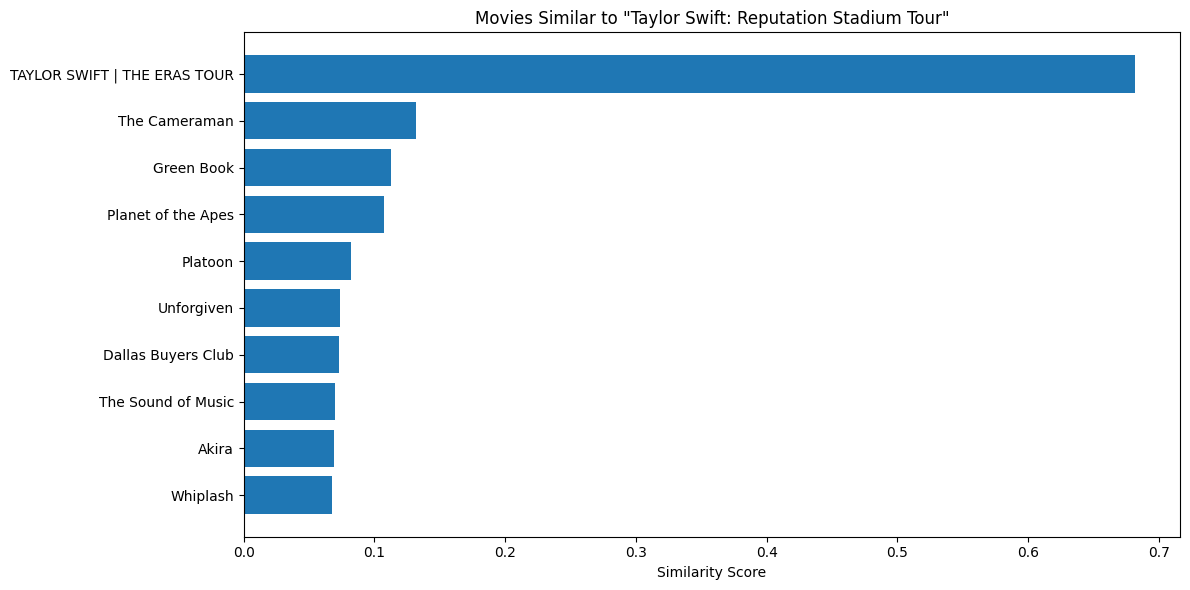

In [ ]:
# 6. Example Movie Recommendations

# Get sample movies from our dataset for testing
sample_movies = movies_df['title'].head(5).tolist()
print("Sample movies in our dataset:")
for i, movie in enumerate(sample_movies, 1):
    print(f"{i}. {movie}")

# Get recommendations for a sample movie
sample_movie = sample_movies[0]
print(f"\nGetting recommendations for: {sample_movie}\n")

recommendations = get_recommendations(sample_movie)
print(recommendations)

# Visualize the similarity scores
plt.figure(figsize=(12, 6))
plt.barh(recommendations['title'], recommendations['similarity_score'])
plt.xlabel('Similarity Score')
plt.title(f'Movies Similar to "{sample_movie}"')
plt.gca().invert_yaxis()  # To show the highest similarity at the top
plt.tight_layout()
plt.show()


In [ ]:
# 7. Search Functionality using the Recommendation Model

def search_movies(query, movies_df, tfidf_vectorizer, cosine_sim_matrix):
    """
    Search for movies based on a query and return the most relevant results
    """
    # Create a dataframe with just the query
    query_df = pd.DataFrame([{'combined_features': query}])
    
    # Transform the query using the same vectorizer
    query_vector = tfidf_vectorizer.transform(query_df['combined_features'])
    
    # Calculate similarity between the query and all movies
    movie_similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()
    
    # Create a dataframe of movies with their similarity scores
    results = pd.DataFrame({
        'title': movies_features_df['title'],
        'overview': movies_features_df['overview'] if 'overview' in movies_features_df.columns else '',
        'similarity': movie_similarities
    })
    
    # Sort by similarity (descending)
    results = results.sort_values('similarity', ascending=False)
    
    # Return top 10 results
    return results.head(10)

# Test the search functionality
search_queries = [
    "crime drama",
    "sci-fi space",
    "comedy romance"
]

for query in search_queries:
    print(f"\nSearch results for: '{query}'")
    results = search_movies(query, movies_df, tfidf_vectorizer, cosine_sim)
    print(results[['title', 'similarity']])



Search results for: 'crime drama'
                   title  similarity
944            Andhadhun    0.309705
883              Shottas    0.269098
52         The Godfather    0.254477
906           The Batman    0.230214
926  Time of the Gypsies    0.225898
812         Nightcrawler    0.213760
58       The Dark Knight    0.200410
68            GoodFellas    0.200378
195                Joker    0.189939
254                    M    0.188129

Search results for: 'sci-fi space'
                       title  similarity
263    2001: A Space Odyssey    0.549806
67              Interstellar    0.509133
377                   Aliens    0.465291
172                    Alien    0.414044
85   The Empire Strikes Back    0.258458
650                  Solaris    0.254911
461       Return of the Jedi    0.221954
841              The Martian    0.203726
930       Planet of the Apes    0.202807
149                Star Wars    0.181786

Search results for: 'comedy romance'
                                 

In [ ]:
# 8. Next Steps and Integration with MLOps Pipeline

'''
This notebook provides an overview of the movie recommendation system.
To integrate this into our full MLOps pipeline, we'll need to:

1. Data Pipeline:
   - Automate data collection from TheMovieDB API using our movie-data-pipeline
   - Store data in Supabase for persistent storage
   - Schedule regular updates (daily/weekly) via Airflow

2. Model Training:
   - Set up automated retraining based on new data
   - Implement experiment tracking (MLflow)
   - Version models and datasets

3. Model Serving:
   - Deploy the recommendation model as an API
   - Implement endpoints for:
     - Get recommendations based on a movie
     - Search movies based on text query
     - Get personalized recommendations based on user history

4. Evaluation & Monitoring:
   - Track recommendation quality metrics
   - Monitor user interactions and feedback
   - Implement A/B testing for model improvements

'''

print("Notebook completed successfully!")


Notebook completed successfully!
